This notebook is by Anastasia Ruzmaikina. 

In this notebook we train a LSTM neural network to predict the log returns of the price of the stock given the history of its log returns. 

The log return of the stock is defined as $$ln(\frac{S_{t+1}}{S_t})$$ and is approximately equal to $$\frac{S_{t+1}-S_t}{S_t}.$$ If $S_t$ was a Geometric Brownian motion, then $$\frac{d S_t}{S_t} = \mu dt + \sigma dW_t$$ and therefore the log return would be a Gaussian stochastic process. 

In real life, we expect $$ln(\frac{S_{t+1}}{S_t})$$ to behave as a random process and to be difficult to predict. This turns out to be the case. The trained LSTM neural network tries to predict the mean value of the process rather than individual fluctuations. This is not surprising: if you trained someone to predict the next roll of a fair dice, the most accurate prediction they could make is to predict the mean. It turns out that once the LSTM neural network is trained, if we use it to predict the running mean, it is not doing any better, because it is already trained to predict the mean.

The question of how to get more accurate predictions from a trained LSTM neural network is anwered in stock_prediction-LSTM-Part2 notebook and the result is very surprising.

The author learned predictions using neural networks from an excellent "Simply Learn" online course.

First we import all of the necessary libraries:

In [1]:
#import the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings

warnings.filterwarnings('ignore', 'DeprecationWarning: The use of \'dynamic_batch_size\' is deprecated. Use the \'batch_size\' argument instead.')


The dataset is the set of log returns of stock prices for an NYSE stock for the period of 5 years ending on 8/30/23.

The dataset is saved as a .csv file and we download it into a Pandas Dataframe 'data'.

In [2]:
data = pd.read_csv('Stock1.csv')
data

,log_returns
0,-0.009987
1,0.005408
2,-0.032775
3,-0.013849
4,-0.032129
...,...
1158,-0.039066
1159,0.012543
1160,-0.039570
1161,0.009037


We can calculate the statistics of the data:

In [3]:
data.describe()

,log_returns
count,1163.000000
mean,-0.000314
std,0.028609
min,-0.282236
25%,-0.014755
50%,0.000938
75%,0.013948
max,0.131991


We see that the dataset has 1163 datapoints and we can plot the data.



In [5]:
x=data
len(x)

1163

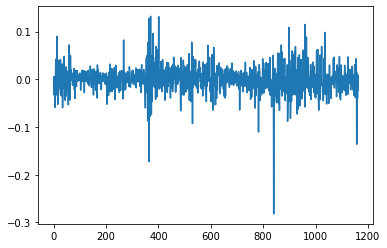

In [4]:

plt.plot(x)


We train the RNN on the first 1101 data points and use the last 62 datapoints as the test set.

In [6]:
#training set
training_set = np.array(x[:1101])
training_set

array([[-0.00998688],
       [ 0.0054076 ],
       [-0.03277452],
       ...,
       [-0.01684907],
       [-0.02795154],
       [ 0.00837796]])

To make the training easier, we first rescale our data so that the dataset has the range $[0,1]$ using the Min-Max Scaler.

In [7]:
#feature scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
training_set_scaled = sc.fit_transform(training_set.reshape(-1,1))

We create the training data structure where the data of the previous 20 timesteps (X_train) are used to predict the next timestep (y_train). (In NLP this is called an n-gram). To see what the new training data looks like, we print out X_train. It is easy to see that X_train consists of 1081 sequences of length 20, where each new sequence is shifted by 1 compared to the previous sequence.

In [8]:
#creating a data structure with 20 timesteps and 1 output
X_train = []
y_train = []
for i in range(20, 1101):
    X_train.append(training_set_scaled[i-20:i, 0]) 
    y_train.append(training_set_scaled[i,0]) #train ith value using i-20:i
X_train, y_train = np.array(X_train), np.array(y_train)  #convert to numpy array
#reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train)

[[[0.65724666]
  [0.69441101]
  [0.60223421]
  ...
  [0.76333486]
  [0.6074994 ]
  [0.61620067]]

 [[0.69441101]
  [0.60223421]
  [0.64792223]
  ...
  [0.6074994 ]
  [0.61620067]
  [0.6739076 ]]

 [[0.60223421]
  [0.64792223]
  [0.60379301]
  ...
  [0.61620067]
  [0.6739076 ]
  [0.77758939]]

 ...

 [[0.67226126]
  [0.70252515]
  [0.59335919]
  ...
  [0.57733761]
  [0.64166434]
  [0.75353409]]

 [[0.70252515]
  [0.59335919]
  [0.66380576]
  ...
  [0.64166434]
  [0.75353409]
  [0.6406804 ]]

 [[0.59335919]
  [0.66380576]
  [0.75386021]
  ...
  [0.75353409]
  [0.6406804 ]
  [0.61387755]]]


Now we are ready to import all of the necessary Keras libraries and packages.



In [10]:
#import keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

2023-10-01 13:14:45.414151: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


We initialize the recurrent neural network:

In [11]:
#initialize rnn
regressor = Sequential()

We start adding LSTM layers. The size of the layers should be as large as possible, but it makes the neural network significantly slower, so here we use the output size of 500 units. The input size is given by the X_train, the training dataset. The 20% dropout means that approximately 20% of neurons would be randomly dropped out during training. This is done to avoid overfitting the training set, because this results in worse predictions on the test set.

In [12]:
#adding the LSTM layer and some Dropout reguralization (drops unnecessary data)
regressor.add(LSTM(units=500, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2)) #can overtrain, to avoid this turn off 20% neurons randomly picked

2023-10-01 13:14:59.778753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-01 13:14:59.781192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-01 13:14:59.783280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

We add another LSTM layer with 500 cells.

In [13]:
#adding a second LSTM layer and some Dropout regularization
regressor.add(LSTM(units=500, return_sequences = True))
regressor.add(Dropout(0.2))

2023-10-01 13:15:00.208787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-01 13:15:00.212117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-01 13:15:00.214238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

We add a third LSTM layer with 500 cells.

In [14]:
#adding a third LSTM layer and some Dropout regularization
regressor.add(LSTM(units=500, return_sequences = True))
regressor.add(Dropout(0.2))

2023-10-01 13:15:00.618073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-01 13:15:00.620074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-01 13:15:00.622275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

We add a forth LSTM layer with 500 cells.

In [15]:
#adding a fourth LSTM layer and some Dropout regularization
regressor.add(LSTM(units=500))
regressor.add(Dropout(0.2))

2023-10-01 13:15:01.031395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-01 13:15:01.033729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-01 13:15:01.035719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Finally we add a dense layer, which is a layer where 1 output is connected to all of the 500 inputs. This is the output layer that gives the predicted value  '𝑦'.
 

In [16]:
#adding the output layer
regressor.add(Dense(units = 1))  #dense means 1 output

Now that RNN is contructed, we compile it and require it to minimize the 'mean squred error' loss function for the output  '𝑦'  as compared with the training set y_train. The optimizer 'adam' is an extension of stochastic gradient descent algorithm which decides how to update the weights of the neural network during the training process and dynamically computes individual learning rates to create an adaptive learing rate required to navigate the optimization landscape during training.

In [17]:
#compile the rnn
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')  #adam optimized for big data

We finally train the RNN for 500 epochs, meaning the learning algorithm would work through the entire dataset 500 times. One epoch means that the weights of the neurons in the RNN have an opportunity to be updated once.

The number of epochs should be as large as possible, but it slows down the training significantly.

In [18]:
#fit rnn to the training set
regressor.fit(X_train, y_train, epochs = 500, batch_size = 32) 
#number of epochs is how many times we go over our data set, batch size so that data is loaded in batches 32 lines5

Epoch 1/500


2023-10-01 13:15:01.464776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-01 13:15:01.467480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-01 13:15:01.469777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

34/34 [==============================] - 35s 816ms/step - loss: 0.4790
Epoch 2/500
34/34 [==============================] - 30s 871ms/step - loss: 0.0087
Epoch 3/500
34/34 [==============================] - 28s 823ms/step - loss: 0.0058
Epoch 4/500
34/34 [==============================] - 28s 838ms/step - loss: 0.0059
Epoch 5/500
34/34 [==============================] - 29s 848ms/step - loss: 0.0063
Epoch 6/500
34/34 [==============================] - 31s 902ms/step - loss: 0.0058
Epoch 7/500
34/34 [==============================] - 34s 995ms/step - loss: 0.0056
Epoch 8/500
34/34 [==============================] - 30s 896ms/step - loss: 0.0058
Epoch 9/500
34/34 [==============================] - 33s 972ms/step - loss: 0.0060
Epoch 10/500
34/34 [==============================] - 32s 935ms/step - loss: 0.0060
Epoch 11/500
34/34 [==============================] - 34s 1s/step - loss: 0.0060
Epoch 12/500
34/34 [==============================] - 30s 868ms/step - loss: 0.0057
Epoch 13/500
34/

34/34 [==============================] - 51s 1s/step - loss: 0.0052
Epoch 198/500
34/34 [==============================] - 51s 1s/step - loss: 0.0051
Epoch 199/500
34/34 [==============================] - 50s 1s/step - loss: 0.0053
Epoch 200/500
34/34 [==============================] - 55s 2s/step - loss: 0.0052
Epoch 201/500
34/34 [==============================] - 51s 2s/step - loss: 0.0052
Epoch 202/500
34/34 [==============================] - 51s 1s/step - loss: 0.0052
Epoch 203/500
34/34 [==============================] - 51s 2s/step - loss: 0.0051
Epoch 204/500
34/34 [==============================] - 51s 2s/step - loss: 0.0051
Epoch 205/500
34/34 [==============================] - 51s 2s/step - loss: 0.0054
Epoch 206/500
34/34 [==============================] - 51s 2s/step - loss: 0.0056
Epoch 207/500
34/34 [==============================] - 52s 2s/step - loss: 0.0052
Epoch 208/500
34/34 [==============================] - 53s 2s/step - loss: 0.0051
Epoch 209/500
34/34 [=========

34/34 [==============================] - 52s 2s/step - loss: 0.0051
Epoch 298/500
34/34 [==============================] - 52s 2s/step - loss: 0.0051
Epoch 299/500
34/34 [==============================] - 52s 2s/step - loss: 0.0052
Epoch 300/500
34/34 [==============================] - 52s 2s/step - loss: 0.0051
Epoch 301/500
34/34 [==============================] - 53s 2s/step - loss: 0.0050
Epoch 302/500
34/34 [==============================] - 53s 2s/step - loss: 0.0051
Epoch 303/500
34/34 [==============================] - 52s 2s/step - loss: 0.0050
Epoch 304/500
34/34 [==============================] - 52s 2s/step - loss: 0.0049
Epoch 305/500
34/34 [==============================] - 53s 2s/step - loss: 0.0052
Epoch 306/500
34/34 [==============================] - 52s 2s/step - loss: 0.0051
Epoch 307/500
34/34 [==============================] - 54s 2s/step - loss: 0.0052
Epoch 308/500
34/34 [==============================] - 53s 2s/step - loss: 0.0049
Epoch 309/500
34/34 [=========

34/34 [==============================] - 54s 2s/step - loss: 0.0049
Epoch 497/500
34/34 [==============================] - 53s 2s/step - loss: 0.0050
Epoch 498/500
34/34 [==============================] - 53s 2s/step - loss: 0.0051
Epoch 499/500
34/34 [==============================] - 53s 2s/step - loss: 0.0049
Epoch 500/500
34/34 [==============================] - 53s 2s/step - loss: 0.0049


We now have a fully trained RNN and move to the testing part. The testing dataset consists of the last 62 datapoints of dataset 'x'.

In [19]:
x = pd.DataFrame(x)
dataset_test = x[1101:]
dataset_train = x[:1101]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)  
inputs = dataset_total[len(dataset_total)-len(dataset_test)-20:].values
inputs = sc.transform(inputs)


Here we show again what the training dataset X_train looks like:

In [20]:
#creating a data structure with 20 timesteps and 1 output
X_train = []
y_train = []
for i in range(20, 1101):
    X_train.append(training_set_scaled[i-20:i, 0])  #column 0
    y_train.append(training_set_scaled[i,0]) #train ith value using i-20:i
X_train, y_train = np.array(X_train), np.array(y_train)  #convert to numpy array
#reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train)

[[[0.65724666]
  [0.69441101]
  [0.60223421]
  ...
  [0.76333486]
  [0.6074994 ]
  [0.61620067]]

 [[0.69441101]
  [0.60223421]
  [0.64792223]
  ...
  [0.6074994 ]
  [0.61620067]
  [0.6739076 ]]

 [[0.60223421]
  [0.64792223]
  [0.60379301]
  ...
  [0.61620067]
  [0.6739076 ]
  [0.77758939]]

 ...

 [[0.67226126]
  [0.70252515]
  [0.59335919]
  ...
  [0.57733761]
  [0.64166434]
  [0.75353409]]

 [[0.70252515]
  [0.59335919]
  [0.66380576]
  ...
  [0.64166434]
  [0.75353409]
  [0.6406804 ]]

 [[0.59335919]
  [0.66380576]
  [0.75386021]
  ...
  [0.75353409]
  [0.6406804 ]
  [0.61387755]]]


The testing dataset X_test has the same structure: sequences of length 20 shifted by 1.


Now we use the trained RNN to make predictions on our testing dataset X_test. Once we have have the predicted values  '𝑦' for the test set, we apply the inverse min-max scaling so that they can be compared to the actual data.

In [21]:
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)  
inputs = dataset_total[len(dataset_total)-len(dataset_test)-20:].values
inputs = sc.transform(inputs)
inputs = inputs.reshape(-1,1)

X_test = []
for i in range(20, 83):
    X_test.append(inputs[i-20:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test,(X_test.shape[0], X_test.shape[1], 1))
predicted = regressor.predict(X_test)
predicted = predicted.reshape(-1,1)
predicted = sc.inverse_transform(predicted) #go back from scaled data to actual values

2023-10-01 22:25:26.337996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-01 22:25:26.341864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-01 22:25:26.345421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 6s 421ms/step


We need the actual values of the test dataset to compare with predicted values. We call the last 62 actual values of dataset 'x', the 'real' dataset.

In [22]:
real = dataset_test.values
real[:]


array([[-0.01526155],
       [-0.02734829],
       [ 0.00773853],
       [ 0.00318472],
       [-0.00384948],
       [-0.0220528 ],
       [ 0.0029867 ],
       [-0.00230712],
       [ 0.00298467],
       [ 0.00378583],
       [ 0.02912634],
       [ 0.00640232],
       [-0.0246568 ],
       [ 0.01233846],
       [ 0.00118601],
       [-0.03347929],
       [-0.01122992],
       [ 0.00863907],
       [ 0.00910642],
       [ 0.00593554],
       [-0.01846123],
       [ 0.00300958],
       [ 0.04683041],
       [-0.03151327],
       [-0.02423536],
       [ 0.01802835],
       [-0.00788155],
       [-0.00821922],
       [ 0.02015319],
       [ 0.00282695],
       [ 0.02062203],
       [-0.00859623],
       [-0.00039854],
       [-0.0221679 ],
       [ 0.01817375],
       [-0.00588709],
       [-0.0126943 ],
       [-0.00108784],
       [ 0.02711212],
       [ 0.0132853 ],
       [ 0.01039916],
       [-0.01183754],
       [-0.01449874],
       [-0.02337245],
       [ 0.00812132],
       [ 0

We graph the actual  $𝑥_𝑡$
  data in the test set in red and the predicted  '𝑦'
  data in the test set in blue. We can see that the RNN is not trying to predict the actual data. It is clear that the trained RNN is predicting the average of the test set rather than the fluctuations.  We believe that this is not because the RNN is not sufficiently trained, but rather because it is 'not trying' to predict the actual values.

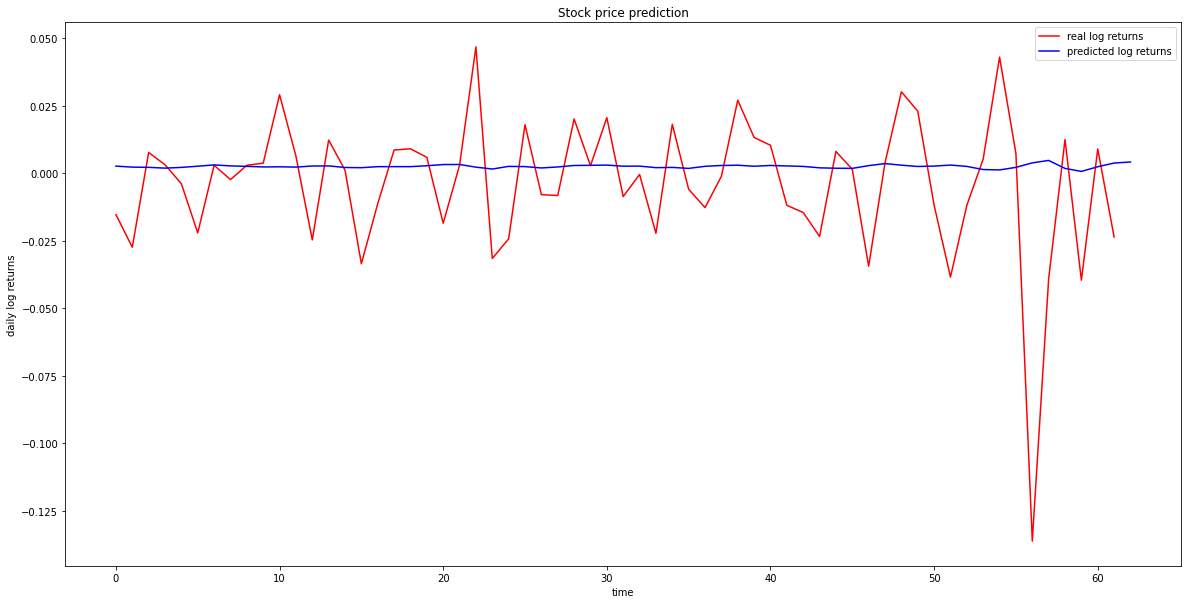

In [27]:
#visualize results
plt.figure(figsize=(20,10))
plt.plot(real[:], color='red', label='real log returns')
plt.plot(predicted[:], color='blue', label='predicted log returns')
plt.title('Stock price prediction')
plt.xlabel('time')
plt.ylabel('daily log returns')
plt.legend()
plt.show()

If instead of comparing the predictions with the actual data, we compare the predictions with the smoothed actual data, i.e. with the moving average of the actual data with the window width equal to 5, the prediction is not better. This means that the data have to be smoothed before the RNN is trained.

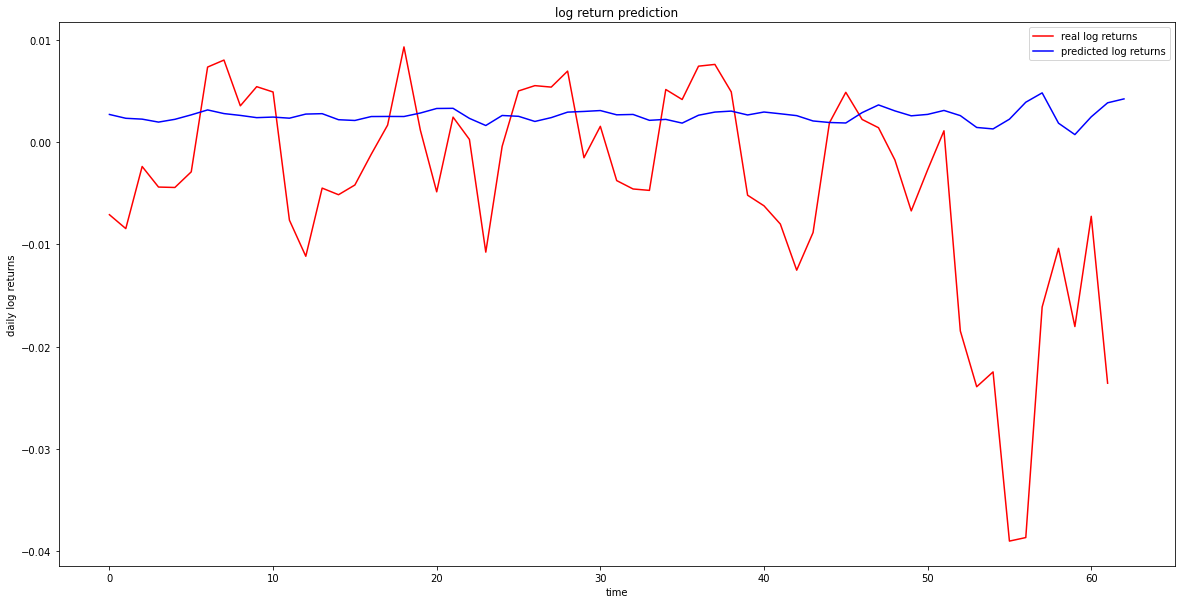

In [29]:
#visualize results
r = []
for i in range(5,len(real)+5):
    r.append(np.array(real[i-5:i]).mean())

plt.figure(figsize=(20,10))
plt.plot(r[:], color='red', label='real log returns')
plt.plot(predicted[:], color='blue', label='predicted log returns')
plt.title('log return prediction')
plt.xlabel('time')
plt.ylabel('daily log returns')
plt.legend()
plt.show()

Conclusions: the LSTM neural network trained for 500 epochs does not try to predict the fluctuations of the log returns, instead it predicts the mean of the log returns. We believe that this is because the RNN perceives the log return data as random and therefore makes the 'best guess' which is the mean.